Reference: https://medium.com/@hunter-j-phillips/overview-the-implemented-transformer-eafd87fe9589

In [1]:
# torch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import pad
from torch import Tensor
from torch.utils.data import DataLoader

import torchtext
import torchtext.datasets as datasets
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.metrics import bleu_score
from torchtext.vocab import build_vocab_from_iterator

from datasets import load_dataset

from transformer_from_scratch.transformer_instantiate import transformer

# importing required libraries
import os
import math
import copy
import time
import spacy
import jieba
import numpy as np
import pandas as pd
import random
import portalocker

# visualization packages
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits import mplot3d
from tqdm import tqdm

### Hyper parameters

In [2]:
MAX_PADDING = 20
MAX_SEQ_LEN = 50
BATCH_SIZE = 128
D_MODEL = 256
D_FFN = 512
N_HEADS = 8
N_LAYERS = 3
N_EPOCHS = 10
DROPOUT = 0.1
LEARNING_RATE = 1e-4
CLIP = 1
CONTINUE = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset_path = 'datasets/opus-100/en-zh'
vocab_path = "checkpoints/opus-100-en-zh-vocab.pt"
model_path = 'checkpoints/transformer-translate.pt'

In [3]:
# url: https://huggingface.co/datasets/Helsinki-NLP/opus-100

os.makedirs(dataset_path, exist_ok=True)

data_files = {
    'train': 'train-00000-of-00001.parquet',
    'validation': 'validation-00000-of-00001.parquet',
    'test': 'test-00000-of-00001.parquet'
}

files_exist = all(os.path.exists(os.path.join(dataset_path, file_name)) for file_name in data_files.values())

if not files_exist:
    en_zh_dataset = load_dataset('Helsinki-NLP/opus-100', 'en-zh')

    # save to parquet file in local
    for split, file_name in data_files.items():
        en_zh_dataset[split].to_parquet(os.path.join(dataset_path, file_name))

en_zh_dataset = load_dataset(
    "parquet", 
    data_files={
        split: os.path.join(dataset_path, file_name) for split, file_name in data_files.items()
    }
)

In [4]:
pd.DataFrame(en_zh_dataset['train']['translation'][:100])

,en,zh
0,Sixty-first session,第六十一届会议
1,I took some medicine for my mu for my mu my mu...,减轻酸... 酸痛的药 减轻酸痛的药
2,It's a challenge. God is challenging you. He's...,上帝在挑战你，他说你是笨蛋
3,"Oh, baby.",.. 寶貝
4,- Lucinda?,- 盧辛達？
...,...,...
95,Take 'em all.,通通拿下
96,I so knowthat. That's what's great.,一点都没错，我很高兴
97,Harlend thinks you're some kind of criminal ma...,哈兰德 感谢你的罪案策划
98,"In short, the US has moved to bring together a...",简言之，美国正在试图团结该地区所有担心中国以邻为壑的贸易和汇率政策的国家。对美国来说，其他八...


### Loading the Tokenizers

In [5]:
def load_tokenizers():
    """
    Load the English tokenizers provided by spaCy

    Returns:
        spacy_en: English tokenizer
    """
    try:
        spacy_en = spacy.load("en_core_web_sm")
    except OSError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    print("Loaded English tokenizer.")
    return spacy_en

In [6]:
spacy_en = load_tokenizers()

Loaded English tokenizer.


### Tokenize the Sequences

In [7]:
def tokenize(text, language):
    """
    Split a string into its tokens using the corresponding tokenizer.

    Args:
        text:     string
        language: en or zh    
    Returns:
        tokenized list of strings 
    """
    if language == 'en':
        return [tok.text.lower() for tok in spacy_en.tokenizer(text)]
    elif language == 'zh':
        return list(jieba.cut(text))

### Yield Tokens

In [8]:
def yield_tokens(sentences, language):
    """
    Return the tokens for the appropriate language.

    Args:
        sentences: List of sentences to tokenize.
        language:  The language code ('en' for English, 'zh' for Chinese).

    Yields:
        sequences based on index
    """
    for sentence in sentences:
        yield tokenize(sentence, language)

### Building the Vocabulary

In [9]:
def build_vocabulary(dataset, language, min_freq=2):
    """
    Builds a vocabulary from a specified language across all splits (train, test, validation) of a dataset.

    Args:
        dataset:  The dataset object containing the 'train', 'test', and 'validation' splits. Each split should contain a 'translation' field with subfields for each language (e.g., 'en' for English, 'zh' for Chinese).
        language: The language code ('en' for English, 'zh' for Chinese) for which the vocabulary will be built. This code should match the subfields in the 'translation' field of the dataset.
        min_freq: The minimum frequency a token must have across the dataset to be included in the vocabulary. Tokens appearing fewer times than this threshold will be excluded. Defaults to 2.

    Returns:
        Vocab: A vocabulary object that maps tokens to indices for the specified language. This vocabulary includes special tokens
               ("<unk>", "<pad>", "<bos>", "<eos>") and all tokens that appear at least 'min_freq' times in the dataset.
    """

    all_sentences = []
    for split in ['train', 'validation', 'test']:
        all_sentences.extend([item['translation'][language] for item in dataset[split]])
    
    vocab = build_vocab_from_iterator(
        yield_tokens(all_sentences, language),
        specials=["<bos>", "<eos>", "<pad>", "<unk>"],
        min_freq=min_freq
    )

    vocab.set_default_index(vocab["<unk>"])

    return vocab

### Load the Vocabulary

In [10]:
def load_vocab(dataset, min_freq=2):
    """
    Load or build the vocabulary for English and Chinese languages.

    Args:
        dataset: The dataset objet containing the 'train', 'test', and 'validation' splits
        min_freq: minimum frequency needed to include a word in the vocabulary
    
    Returns:
        src_vocab: English vocabulary
        trg_vocab: Chinese vocabulary  
    """
    
    os.makedirs(os.path.dirname(vocab_path), exist_ok=True)
    if not os.path.exists(vocab_path):
        # build the English/Chinese vocabulary if it does not exist
        src_vocab = build_vocabulary(dataset, "en", min_freq)
        trg_vocab = build_vocabulary(dataset, "zh", min_freq)
        
        torch.save((src_vocab, trg_vocab), vocab_path)
    else:
        # load the vocab if it exists
        src_vocab, trg_vocab = torch.load(vocab_path)

    print("Vocabulary loaded.\nSource vocab size:", len(src_vocab), "\nTarget vocab size:", len(trg_vocab))
    return src_vocab, trg_vocab

In [11]:
src_vocab, trg_vocab = load_vocab(en_zh_dataset)

Vocabulary loaded.
Source vocab size: 81674 
Target vocab size: 122394


### Indexing Sequences

In [12]:
def data_process(raw_data, file_name):
    """
    Process raw sentences by tokenizing and converting to integers based on the vocabulary.

    Args:
        raw_data:  English-Chinese sentence pairs
        src_vocab: English vocabulary
        trg_vocab: Chinese vocabulary 
        file_name: Name of the file to save/load processed data
    
    Returns:
        data: tokenized data converted to index based on vocabulary
    """
    processed_data_path = os.path.join('checkpoints', file_name)

    if os.path.exists(processed_data_path):
        print(f'Loading processed data from {processed_data_path}')
        data = torch.load(processed_data_path)
    else:
        data = []
        # loop through each sentence pair
        for item in tqdm(raw_data, desc='Processing'):

            # tokenize the sentence and convert each word to an integers
            src_tensor = torch.tensor([src_vocab[token] for token in tokenize(item['translation']['en'], 'en')], dtype=torch.long) 
            trg_tensor = torch.tensor([trg_vocab[token] for token in tokenize(item['translation']['zh'], 'zh')], dtype=torch.long)

            data.append((src_tensor, trg_tensor))

        os.makedirs(os.path.dirname(processed_data_path), exist_ok=True)

        print(f'Saving processed data to {processed_data_path}')
        torch.save(data, processed_data_path)
    
    return data

### Generating Batches

In [13]:
BOS_IDX = trg_vocab['<bos>']
EOS_IDX = trg_vocab['<eos>']
PAD_IDX = trg_vocab['<pad>']

In [14]:
def generate_batch(data_batch):
    """
    Process indexed-sequences by adding <bos>, <eos>, and <pad> tokens.

    Args:
        data_batch: English-Chinese indexed-sentence pairs

    Returns:
        two batches: one for English and one for Chinese
    """
    src_batch, trg_batch = [], []

    for (src_item, trg_item) in data_batch:
        # add <bos> and <eos> indices before and after sentence
        src_item = torch.cat([torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0).to(device)
        trg_item = torch.cat([torch.tensor([BOS_IDX]), trg_item, torch.tensor([EOS_IDX])], dim=0).to(device)

        # add padding
        src_batch.append(pad(
            src_item,
            (0, MAX_PADDING - len(src_item)),
            value=PAD_IDX
        ))

        trg_batch.append(pad(
            trg_item,
            (0, MAX_PADDING - len(trg_item)),
            value=PAD_IDX
        ))

    return torch.stack(src_batch), torch.stack(trg_batch)

### Preprocessing the Data

In [15]:
train_data = data_process(en_zh_dataset['train'], 'opus-100-en-zh-train-processed.pt')
valid_data = data_process(en_zh_dataset['validation'], 'opus-100-en-zh-valid-processed.pt')
test_data = data_process(en_zh_dataset['test'], 'opus-100-en-zh-test-processed.pt')

Loading processed data from checkpoints/opus-100-en-zh-train-processed.pt
Loading processed data from checkpoints/opus-100-en-zh-valid-processed.pt
Loading processed data from checkpoints/opus-100-en-zh-test-processed.pt


In [16]:
train_iter = DataLoader(
    to_map_style_dataset(train_data),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=generate_batch
)
valid_iter = DataLoader(
    to_map_style_dataset(valid_data),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=generate_batch
)
test_iter = DataLoader(
    to_map_style_dataset(test_data),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=generate_batch
)

### Creating the Model

In [17]:
model = transformer(
    src_vocab=src_vocab,
    trg_vocab=trg_vocab,
    d_model=D_MODEL,
    d_ffn=D_FFN,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    device=device,
    dropout=DROPOUT,
    max_seq_len=MAX_SEQ_LEN
).to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 87,650,330 trainable parameters


### Training functions

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    """
    Train the model on the given data.

    Args:
        model:     Transformer model to be trained
        iterator:  data to be trained on
        optimizer: optimizer for updating parameters
        criterion: loss function for updating parameters
        clip:      value to help prevent exploding gradients

    Returns:
        loss for epoch
    """

    # set the model to training mode
    model.train()

    epoch_loss = 0

    progress_bar = tqdm(iterator, desc='Training'.ljust(10), leave=True)

    # loop through each batch in the iterator
    for i, batch in enumerate(progress_bar):
        # set the source and target batches
        src, trg = batch

        # zero the gradients
        optimizer.zero_grad()

        # logits for each output
        logits = model(src, trg[:, :-1])

        # expected output
        expected_output = trg[:, 1:]

        # calculate the loss
        loss = criterion(
            logits.contiguous().view(-1, logits.shape[-1]),
            expected_output.contiguous().view(-1)
        )

        # backpropagation
        loss.backward()

        # clip the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update the loss
        optimizer.step()

        # update the loss
        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    """
    Evaluate the model on the given data.

    Args:
        model:     Transformer model to be trained
        iterator:  data to be evaluated
        criterion: loss function for assessing outputs

    Returns:
        loss for the data
    """

    # set the model to evaluation mode
    model.eval()

    epoch_loss = 0

    # evaluate without updating gradients
    with torch.no_grad():
        progress_bar = tqdm(iterator, desc='Evaluating'.ljust(10), leave=True)
        # loop through each batch in the iterator
        for i, batch in enumerate(progress_bar):

            # set the source and target batches
            src, trg = batch

            # logits for each output
            logits = model(src, trg[:, :-1])

            # expected output
            expected_output = trg[:, 1:]

            # calculate the loss
            loss = criterion(
                logits.contiguous().view(-1, logits.shape[-1]),
                expected_output.contiguous().view(-1)
            )

            epoch_loss += loss.item()
            
            progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training the model

In [22]:
best_valid_loss = float('inf')
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

if os.path.exists(model_path):
    if CONTINUE:
        print('Loading model and continuing training.')
        model.load_state_dict(torch.load(model_path, map_location=device))
    else:
        print("Model already exists. Skipping training.")
        exit() 
else:
    print("Starting training...")
    
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model when it performs better than the previous run
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Loading model and continuing training.


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 13.42it/s, loss=3.12]


Epoch: 01 | Time: 27m 44s
	Train Loss: 2.797 | Train PPL:  16.390
	 Val. Loss: 3.055 |  Val. PPL:  21.230


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 13.40it/s, loss=3.07]


Epoch: 02 | Time: 27m 43s
	Train Loss: 2.637 | Train PPL:  13.965
	 Val. Loss: 2.996 |  Val. PPL:  20.014


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 13.34it/s, loss=2.92]


Epoch: 03 | Time: 27m 43s
	Train Loss: 2.517 | Train PPL:  12.389
	 Val. Loss: 2.965 |  Val. PPL:  19.394


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 13.52it/s, loss=2.97]


Epoch: 04 | Time: 27m 43s
	Train Loss: 2.421 | Train PPL:  11.255
	 Val. Loss: 2.972 |  Val. PPL:  19.537


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 13.42it/s, loss=3.04]

Epoch: 05 | Time: 27m 43s
	Train Loss: 2.340 | Train PPL:  10.379
	 Val. Loss: 2.983 |  Val. PPL:  19.747


### Evaluating the model

In [23]:
model.load_state_dict(torch.load(model_path, map_location=device))

test_loss = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

Evaluating: 100%|██████████| 15/15 [00:01<00:00, 13.38it/s, loss=2.84]

Test Loss: 2.860 | Test PPL:  17.468


### Inference

In [22]:
def translate(sentence, model, max_seq_len=MAX_SEQ_LEN):
    """
    Translate a English sentence to its Chinese equivalent.

    Args:
        sentence:    English sentence to be translate to Chinese
        model:       Transformer model used for translation
        device:      device to perform translation on
        max_seq_len: maximum token length for translation

    Returns:
        src:                    return the tokenized input
        trg_input:              return the input to the decoder before the final output
        trg_output:             return the final translation, shifted right
        attention_probs:        return the attention scores for the decoder heads
        masked_attention_probs: return the masked attention scores for the decoder heads
    """
    model.load_state_dict(torch.load(model_path, map_location=device))

    model.eval()

    # tokenize and index the provided string
    if isinstance(sentence, str):
        src = ['<bos>'] + [token.text.lower() for token in spacy_en(sentence)] + ['<eos>']
    else:
        src = ['<bos>'] + sentence + ['<eos>']

    # convert to integers
    src_indexes = [src_vocab[token] for token in src]

    # convert list to tensor (batch_size, seq_len)
    src_tensor = torch.tensor(src_indexes).int().unsqueeze(0).to(device)

    # set <bos> token for target generation
    trg_indexes = [trg_vocab.get_stoi()['<bos>']]

    # generate new tokens
    for i in range(max_seq_len):

        trg_tensor = torch.tensor(trg_indexes).int().unsqueeze(0).to(device)

        # generate the next token
        with torch.no_grad():

            # generate the logits
            logits = model.forward(src_tensor, trg_tensor)

            # select the newly predicted token, logits (batch_size, seq_len, vocab_size)
            pred_token = logits.argmax(2)[:, -1].item()

            if pred_token == trg_vocab.get_stoi()['<eos>'] or i == (max_seq_len - 1):

                # decoder input
                trg_input = trg_vocab.lookup_tokens(trg_indexes)

                # decoder output
                trg_output = trg_vocab.lookup_tokens(logits.argmax(2).squeeze(0).tolist())

                return src, trg_input, trg_output, model.decoder.attention_probs, model.decoder.masked_attention_probs

            else:
                trg_indexes.append(pred_token)

In [23]:
src_sentence = 'One of the most famous quotes in the field of artificial intelligence is by Alan Turing: "Can machines think?"'

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate(src_sentence, model)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {trg_output}')

source = ['<bos>', 'one', 'of', 'the', 'most', 'famous', 'quotes', 'in', 'the', 'field', 'of', 'artificial', 'intelligence', 'is', 'by', 'alan', 'turing', ':', '"', 'can', 'machines', 'think', '?', '"', '<eos>']
target input = ['<bos>', '最', '著名', '的', '引述', '人工', '情报', '领域', '的', '引述', '人', '是', 'Alan', ' ', 'Ntakirutimana', '：', '“', '可以', '用', '”', '的', '“', '<unk>', '”', '来', '解释', '”', '的', '“', '<unk>', '”', '<unk>', '吗', '？']
target output = ['最', '著名', '的', '引述', '人工', '情报', '领域', '的', '引述', '人', '是', 'Alan', ' ', 'Ntakirutimana', '：', '“', '可以', '用', '”', '的', '“', '<unk>', '”', '来', '解释', '”', '的', '“', '<unk>', '”', '<unk>', '吗', '？', '<eos>']


### Visualization

In [55]:
def attention_visualization(src, trg, attention, n_heads=N_HEADS, n_rows=4, n_cols=2):
    """
    Display the attention matrix for each head of a sequence.

    Args:
        src: tokenized source sentence
        trg: tokenized target sentence
        attention: attention scores for the heads
        n_heads: number of heads
        n_rows: number of rows
        n_cols: number of columns
    """

    # ensure the number of rows and columns are equal to the number of heads
    assert n_rows * n_cols == n_heads

    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.rcParams['axes.unicode_minus']=False

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 24), squeeze=False)

    # Adjust the spacing of the subplots
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # visualize each head
    for i, ax in enumerate(axes.flatten()):

        # select the respective head and make it a numpy array for plotting
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        # plot the matrix
        cax = ax.matshow(_attention, cmap='viridis')

        # Set the size of the labels and add padding to improve label clarity
        ax.tick_params(labelsize=9.5, labelrotation=45, axis='x', which='major', pad=5)
        ax.tick_params(labelsize=9.5, axis='y', which='major', pad=5)

        # set the indices for the tick marks
        ax.set_xticks(range(len(src)))
        ax.set_yticks(range(len(trg)))

        # Set tick labels for source and target sentences
        ax.set_xticklabels(src, rotation=45, ha='left')
        ax.set_yticklabels(trg)

        # Add a color bar for each subplot
        fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3265/1274346772.py:49: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3265/1274346772.py:49: UserWarning: Glyph 33879 (\N{CJK UNIFIED IDEOGRAPH-8457}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3265/1274346772.py:49: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3265/1274346772.py:49: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3265/1274346772.py:49: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3265/1274346772.py:49: UserWarning: Glyph 36848 (\N{CJK UNIFIED IDEOGRAPH-8FF0}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3265/1274346772.py:49: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  plt.tight_l

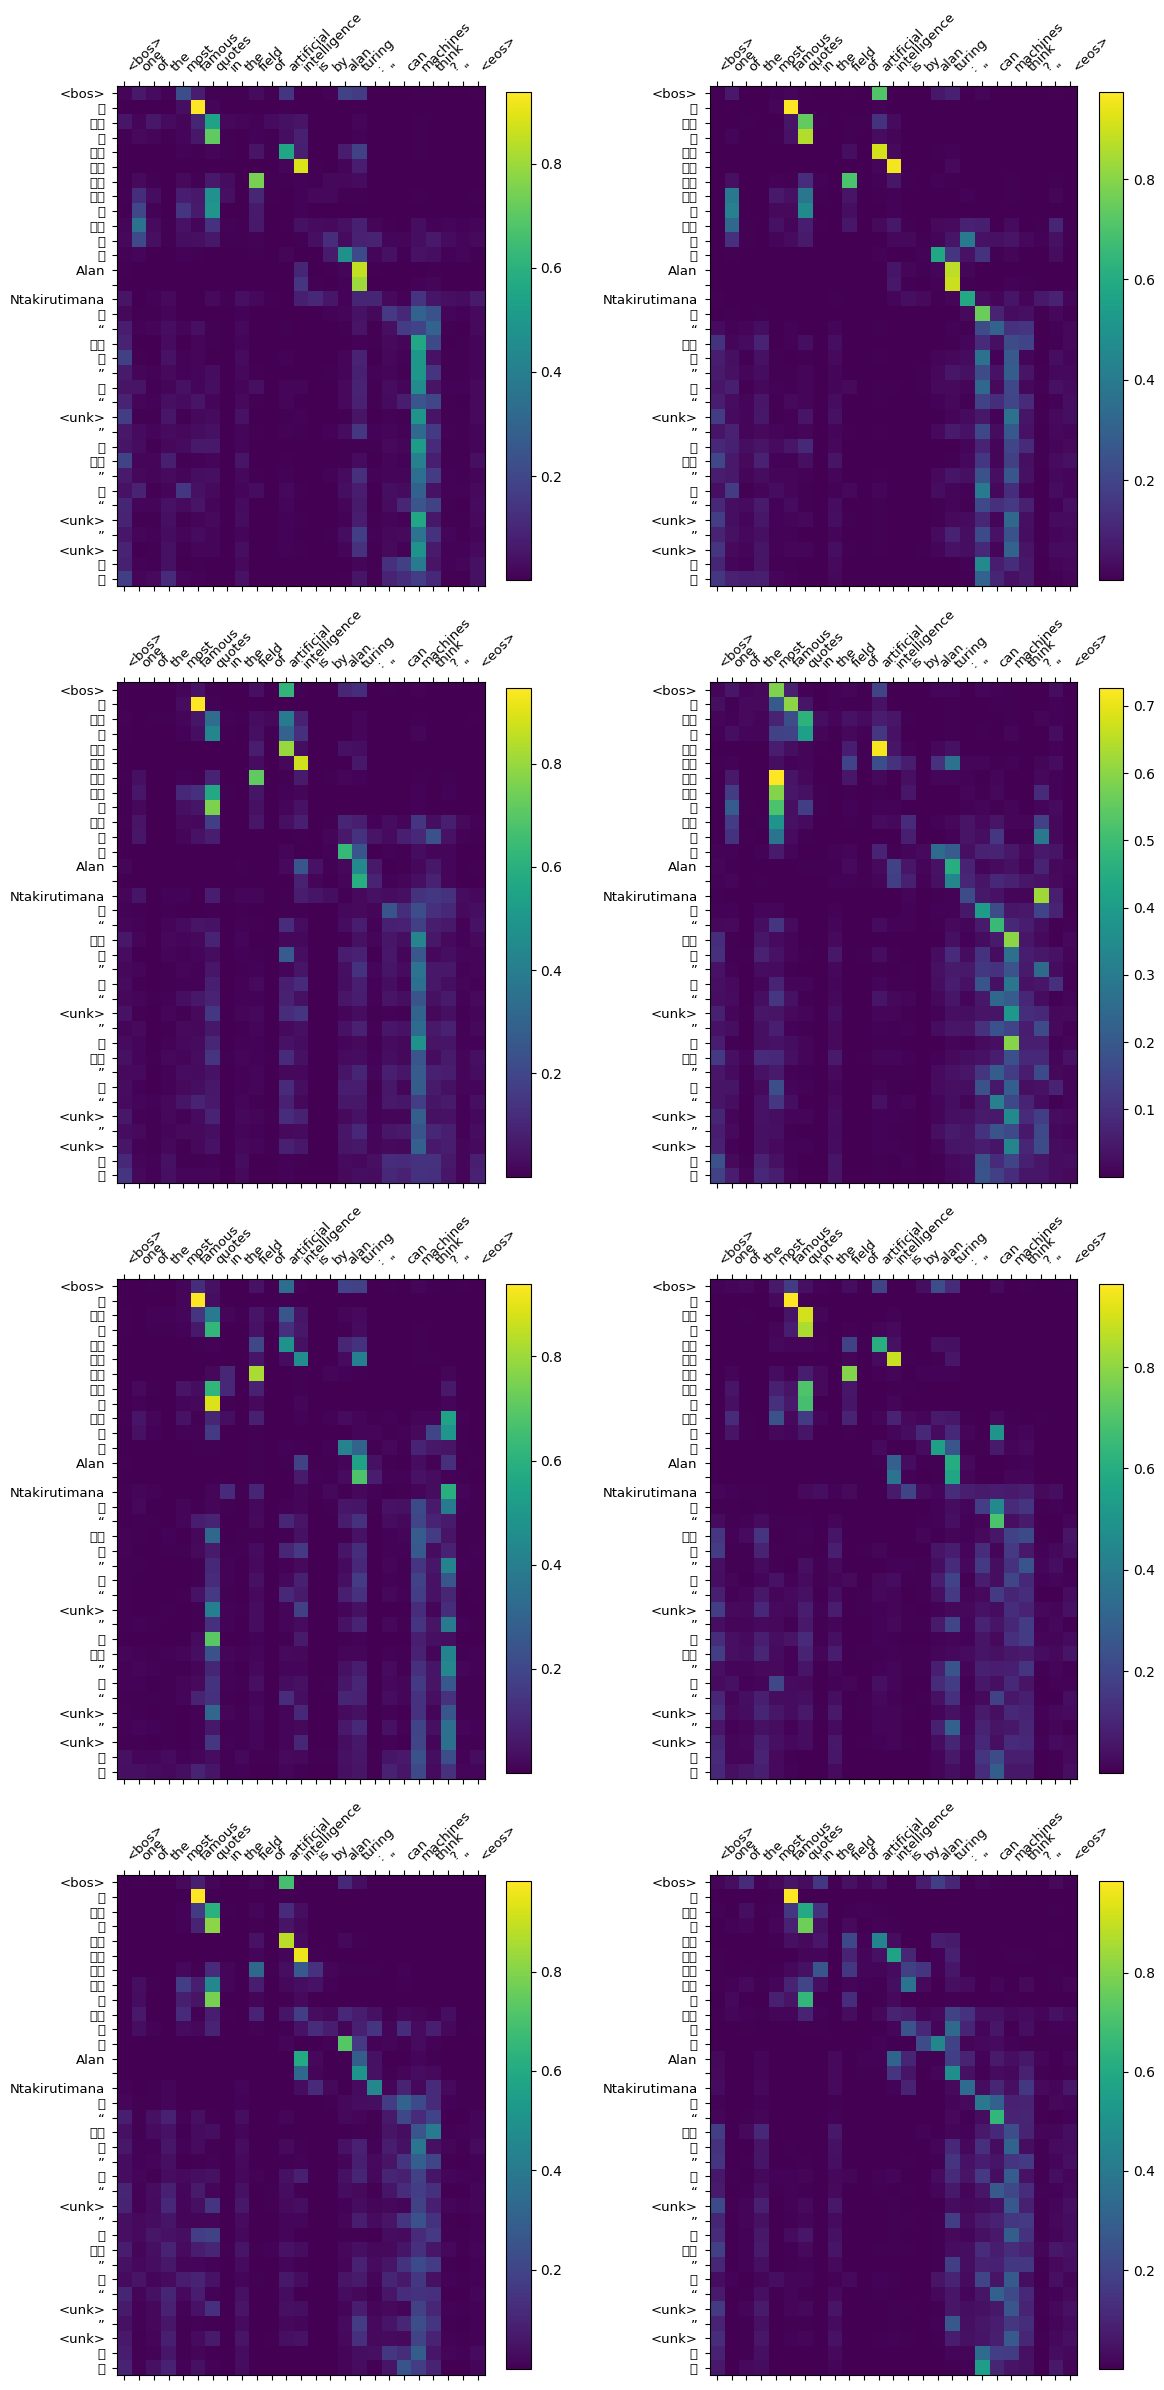

In [56]:
attention_visualization(src, trg_input, attention_probs)

### Evaluation

#### BLEU Score

Bilingual evaluation understudy (BLEU) is a commonly used metric to evaluate machine translation models. The score ranges between 0 and 1, with a 1 meaning the prediction and expected translation are identical.

According to Google’s AutoML documentation, a BLEU score’s value can have the following meanings (in terms of percentage):
- < 10: almost useless
- 10-19: hard to understand
- 20-29: understandable but significant grammatical errors
- 30-39: understandable to good
- 40-49: high quality
- 50-59: high quality, adequate, and fluent
- \> 60: better than human quality

In [99]:
def compute_metrics(model, iterator):
    """
    Generate predictions for the provided iterator.

    Args:
        model: Transformer model to be trained
        iterator: data to be evaluated

    Returns:
        predictions: list of predictions, which are tokenized strings
        labels: list of expected output, which are tokenized strings
    """

    model.load_state_dict(torch.load(model_path, map_location=device))

    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        # loop through each batch in the iterator
        for i, batch in enumerate(iterator):
            src, trg = batch

            src_indices = src.tolist()
            trg_indices = trg.tolist()

            for src, trg in zip(src_indices, trg_indices):

                # predict the output
                src, trg_input, trg_output, attention_probs, masked_attention_probs = translate(src_vocab.lookup_tokens(src), model)

                # prediction | remove <eos> token
                predictions.append(trg_output[:-1])

                # expected output | add extra dim for calculation
                labels.append([trg_vocab.lookup_tokens(trg)])

    return predictions, labels

In [ ]:
predictions, labels = compute_metrics(model, test_iter)
bleu_score(predictions, labels)